In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# Load the dataset
data = pd.read_excel("/content/Automated Credit Scoring System(1).xlsx")



#EDA

Basic Statistics and Visualizations

In [3]:
# Display descriptive statistics for the numerical features
print(data.describe())
# Display the first few rows of the dataset
print(data.head())

        Unnamed: 0  ApplicantID          Age   Dependents       Income  \
count  5000.000000  5000.000000  5000.000000  5000.000000    5000.0000   
mean   2499.500000  2500.500000    43.668400     2.023200  115836.5948   
std    1443.520003  1443.520003    15.195625     1.412891   49345.7260   
min       0.000000     1.000000    18.000000     0.000000   30040.0000   
25%    1249.750000  1250.750000    30.000000     1.000000   73126.0000   
50%    2499.500000  2500.500000    44.000000     2.000000  115674.0000   
75%    3749.250000  3750.250000    57.000000     3.000000  159055.7500   
max    4999.000000  5000.000000    69.000000     4.000000  199912.0000   

       YearsEmployed  MonthlyExpenses  DebtToIncomeRatio  CreditScore  \
count    5000.000000      5000.000000        5000.000000  5000.000000   
mean       19.834000      5303.509800           0.498138   577.230600   
std        11.673804      2759.837405           0.287773   158.812511   
min         0.000000       501.000000    

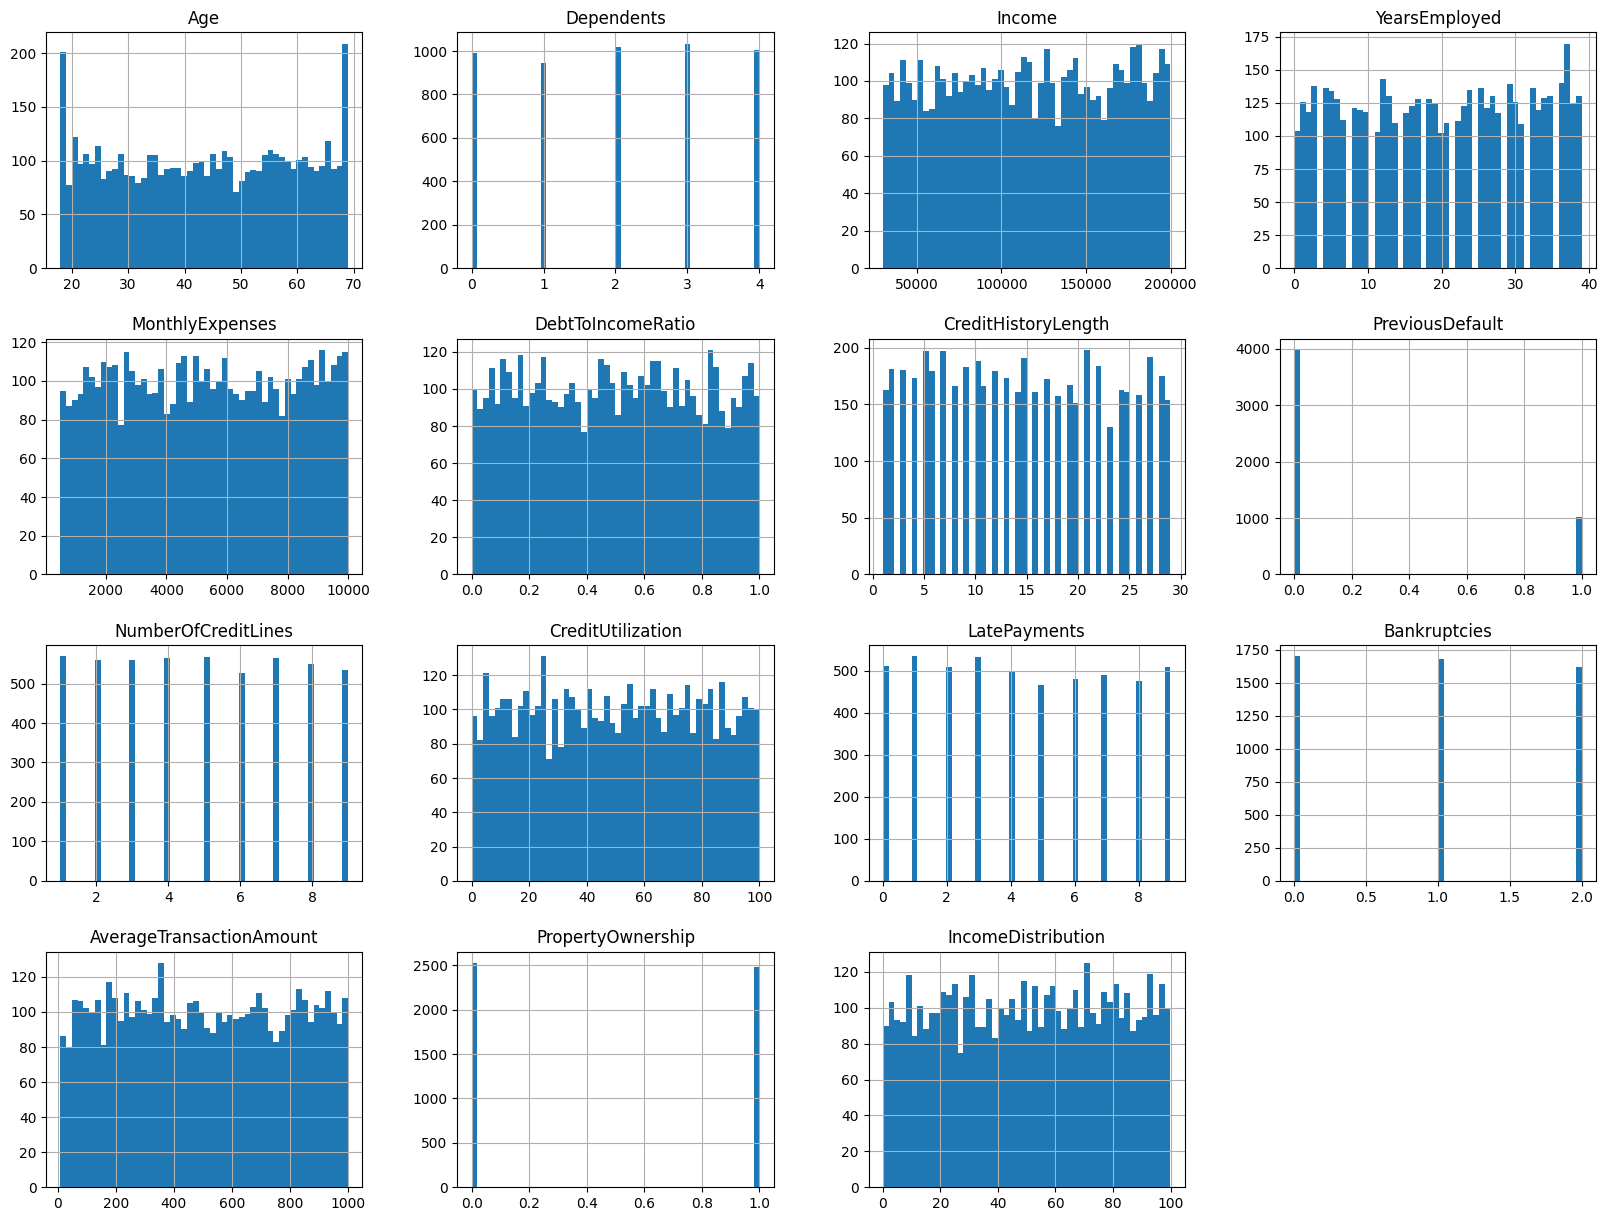

In [4]:
# Define the feature and target columns
numerical_cols = [
    'Age', 'Dependents', 'Income', 'YearsEmployed', 'MonthlyExpenses',
    'DebtToIncomeRatio', 'CreditHistoryLength', 'PreviousDefault',
    'NumberOfCreditLines', 'CreditUtilization', 'LatePayments',
    'Bankruptcies', 'AverageTransactionAmount', 'PropertyOwnership',
    'IncomeDistribution'
]
categorical_cols = [
    'Gender', 'MaritalStatus', 'Education', 'EmploymentStatus', 'IncomeSource',
    'TransactionFrequency', 'TransactionType', 'TransactionHistory',
    'ResidentialStatus', 'Location', 'EmploymentSector'
]

# Convert the credit score to a binary target
threshold = 700
data['CreditBinary'] = (data['CreditScore'] > threshold).astype(int)

# Visualization
# Histograms for numerical features
data[numerical_cols].hist(bins=50, figsize=(20,15))
plt.show()

Boxplots for Outliers

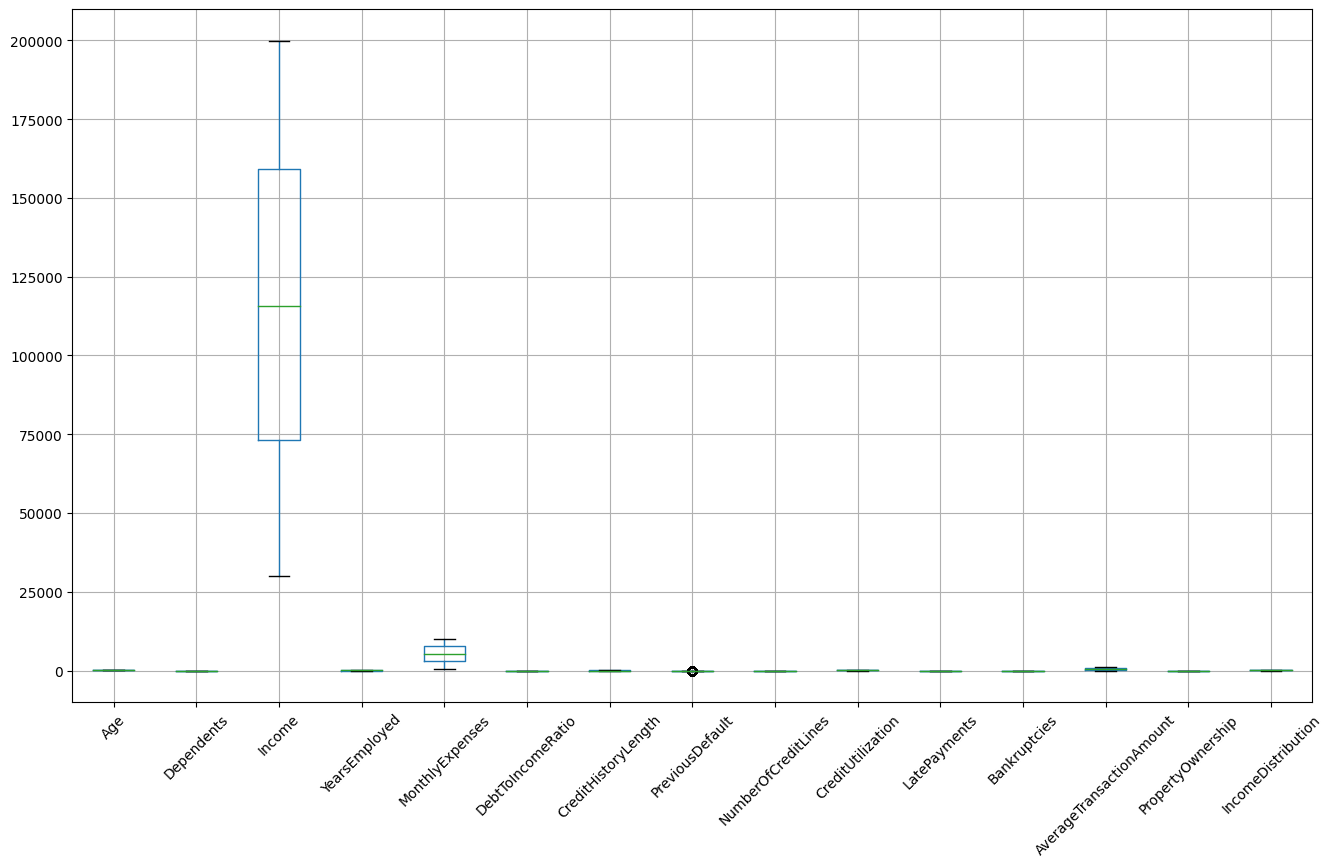

In [ ]:
# Use boxplots to check for outliers in numerical data
fig, ax = plt.subplots(figsize=(16,9))
data.boxplot(column=numerical_cols, ax=ax)
plt.xticks(rotation=45)
plt.show()


Correlation Matrix

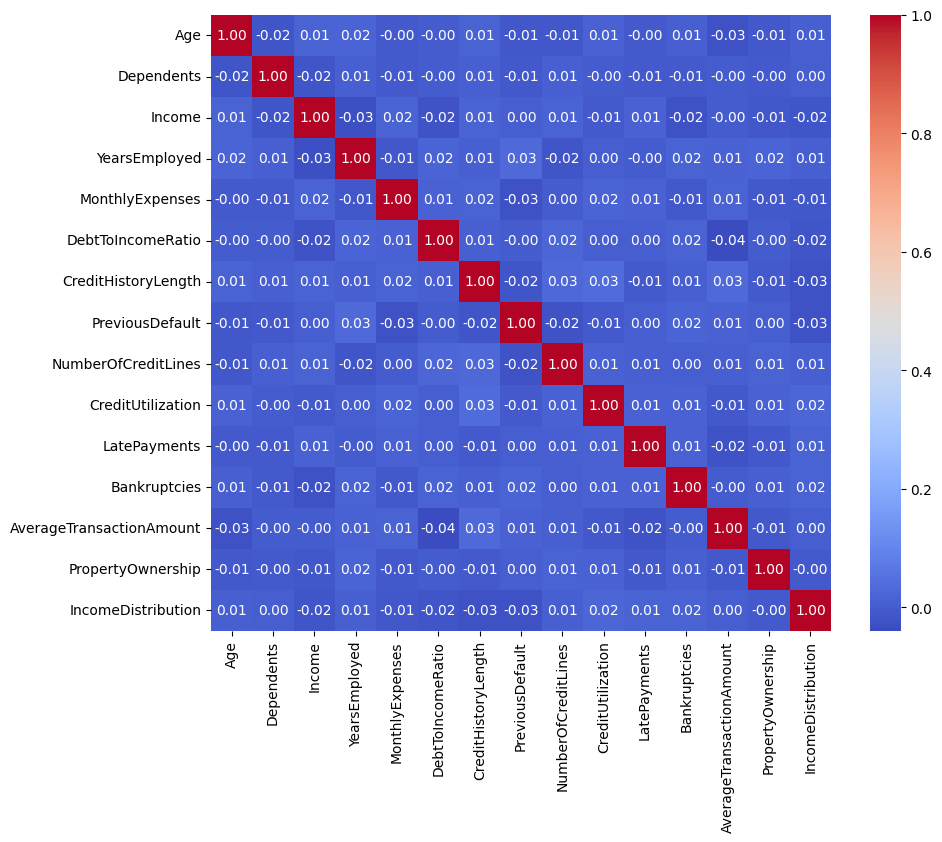

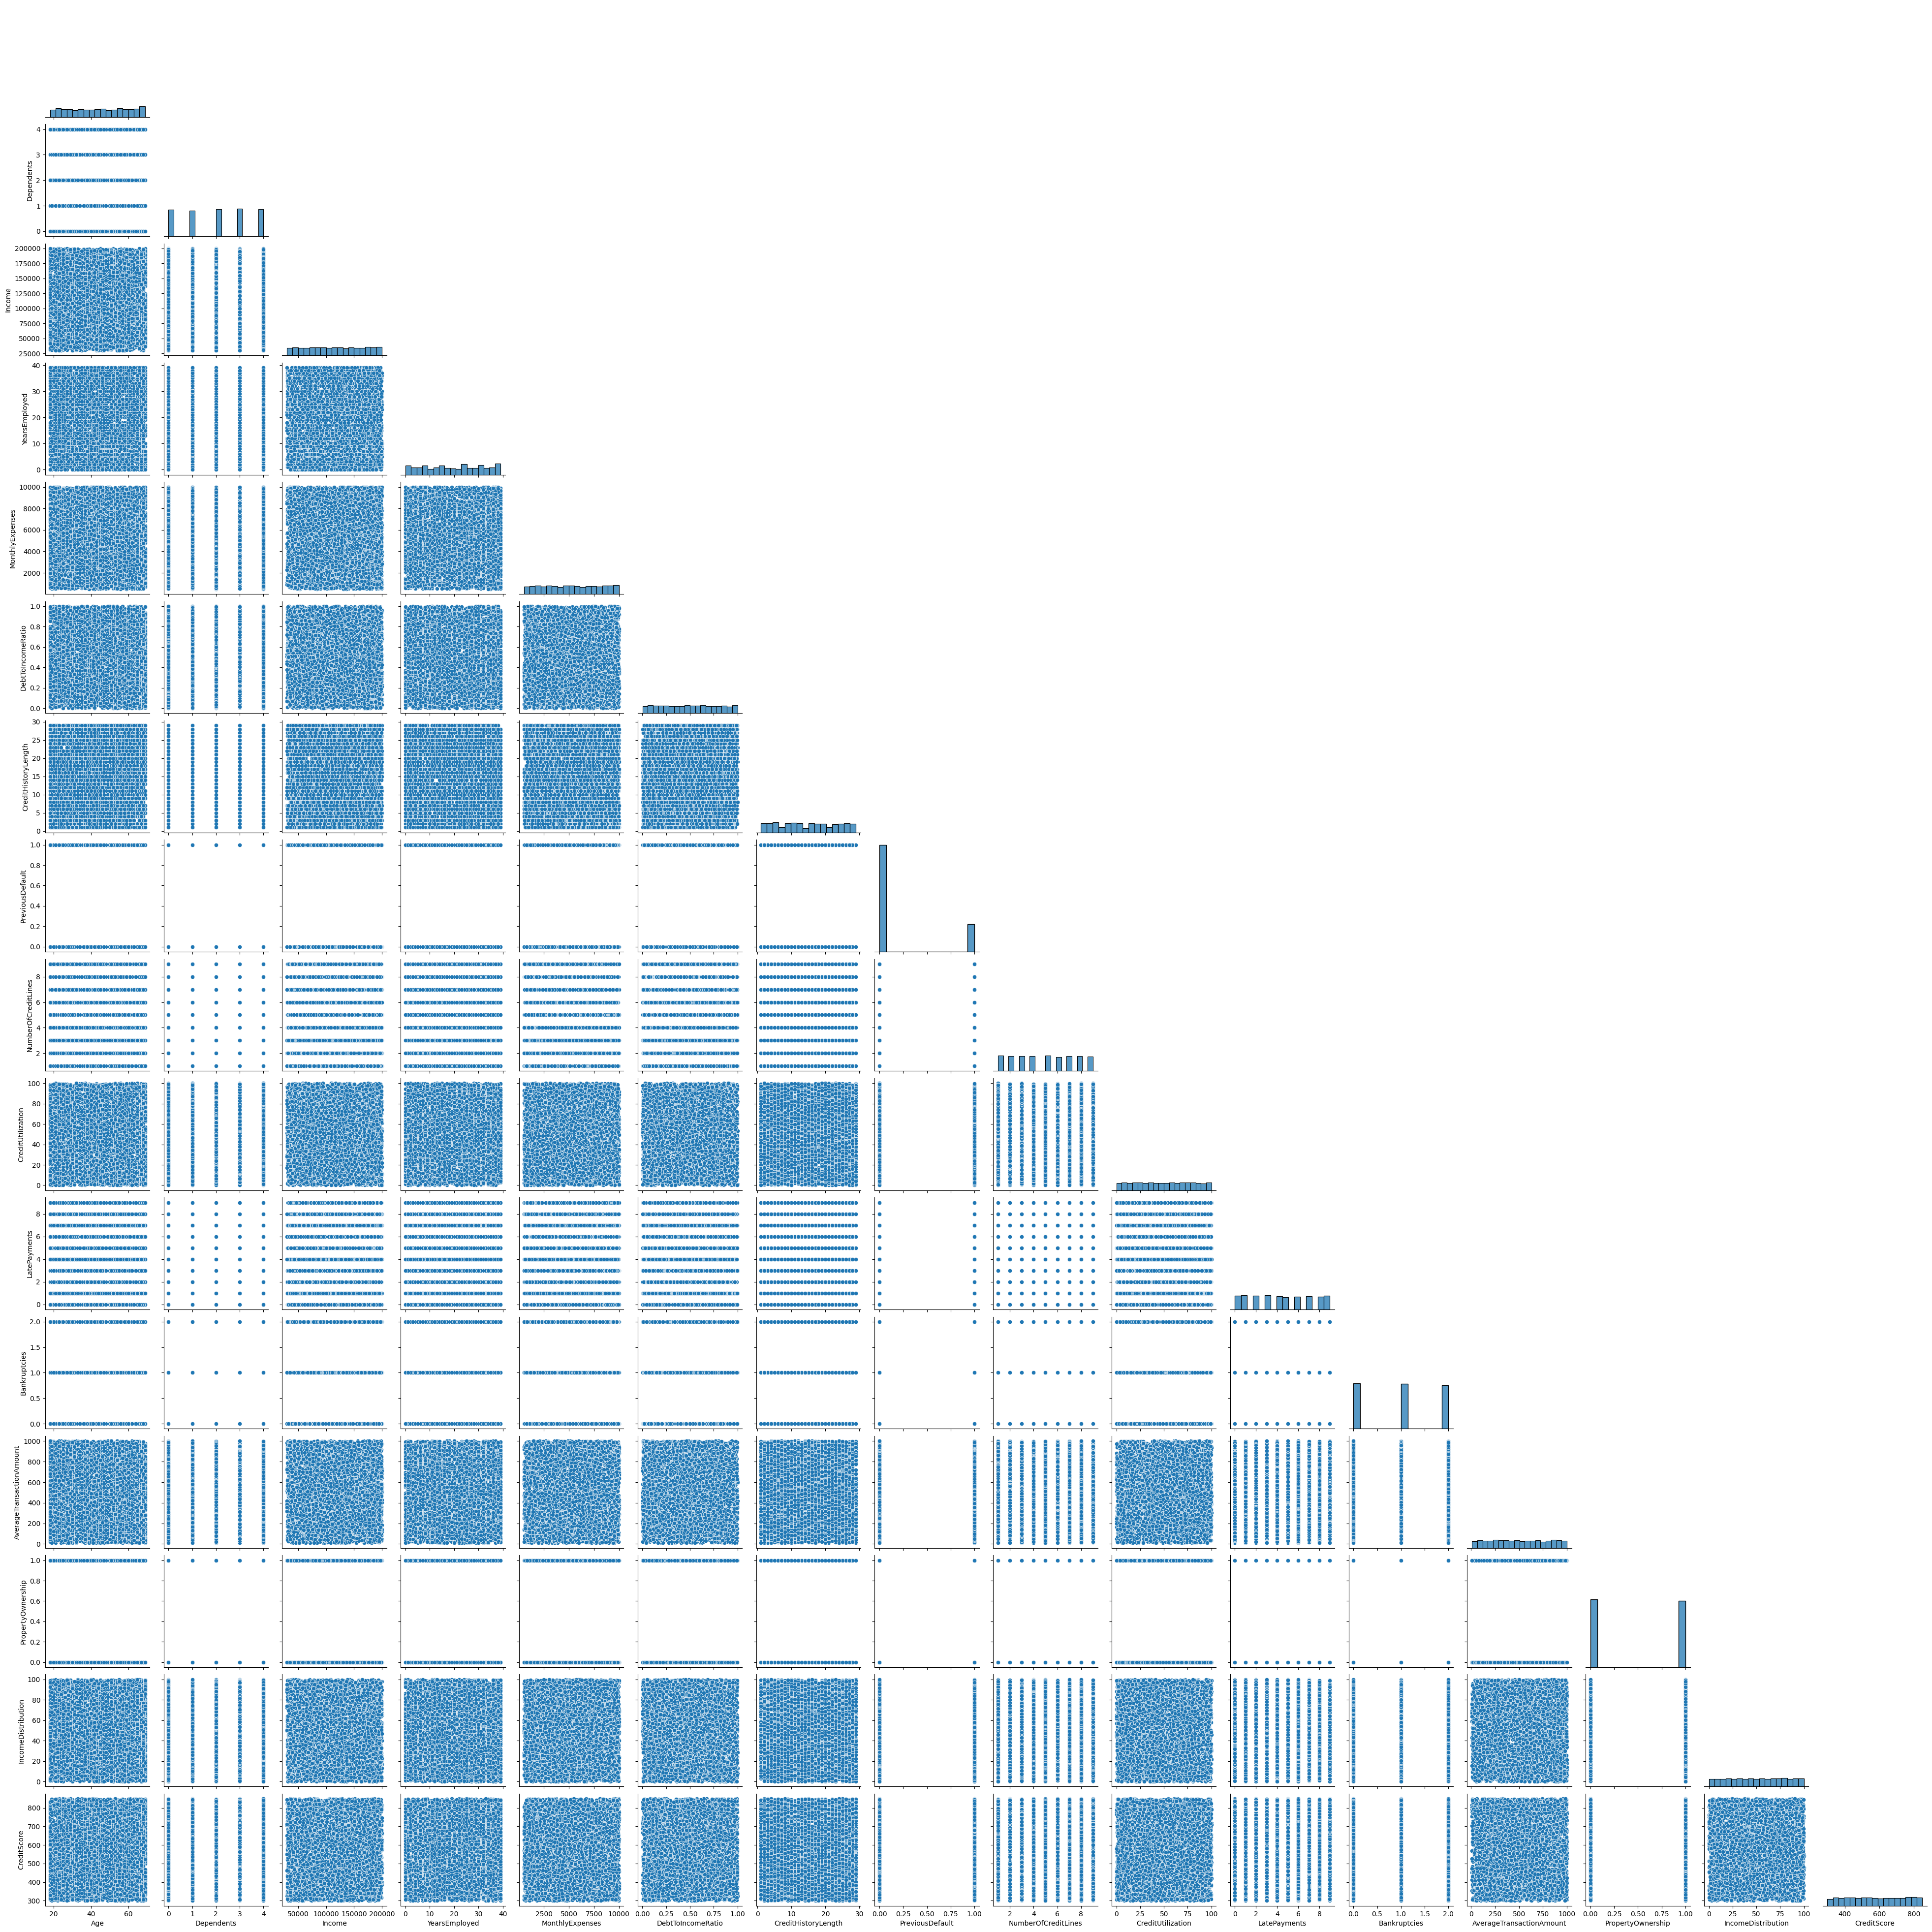

In [ ]:
# Correlation matrix to see potential relationships between features
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

print("\n\n\n")

# Plot a detailed correlation plot for 'CreditScore' with other features
sns.pairplot(data[numerical_cols + ['CreditScore']], kind='scatter', diag_kind='hist', corner=True)
plt.show()


Categorical Data Visualization

In [5]:
for col in categorical_cols:
    print(data[col].value_counts())



Gender
Female    1725
Male      1686
Other     1589
Name: count, dtype: int64
MaritalStatus
Divorced    1282
Married     1273
Widowed     1236
Single      1209
Name: count, dtype: int64
Education
High School    1311
Bachelor       1246
Master         1240
PhD            1203
Name: count, dtype: int64
EmploymentStatus
Employed         1678
Self-employed    1669
Unemployed       1653
Name: count, dtype: int64
IncomeSource
Investment    1692
Business      1657
Salary        1651
Name: count, dtype: int64
TransactionFrequency
High      1709
Medium    1671
Low       1620
Name: count, dtype: int64
TransactionType
Entertainment    1732
Retail           1645
Utilities        1623
Name: count, dtype: int64
TransactionHistory
Data    5000
Name: count, dtype: int64
ResidentialStatus
Rent    2565
Own     2435
Name: count, dtype: int64
Location
Urban       1690
Rural       1673
Suburban    1637
Name: count, dtype: int64
EmploymentSector
Government       1692
Self-employed    1675
Private          1

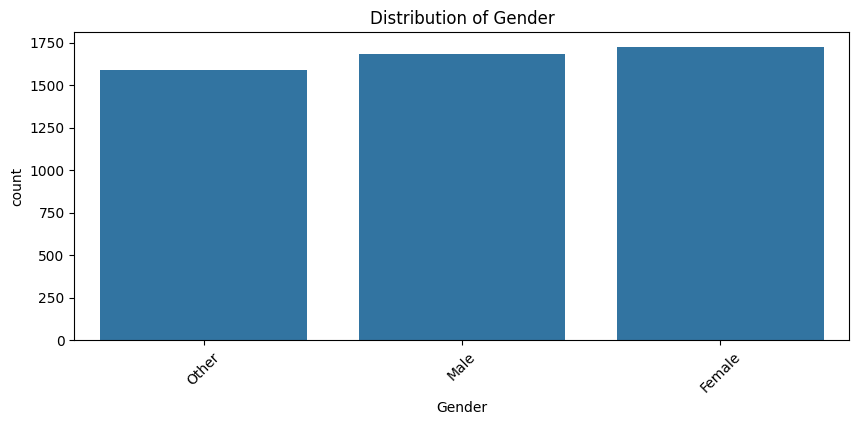

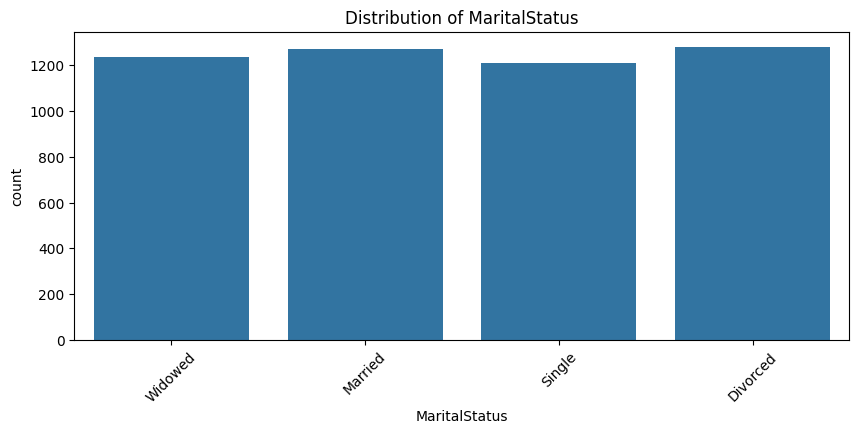

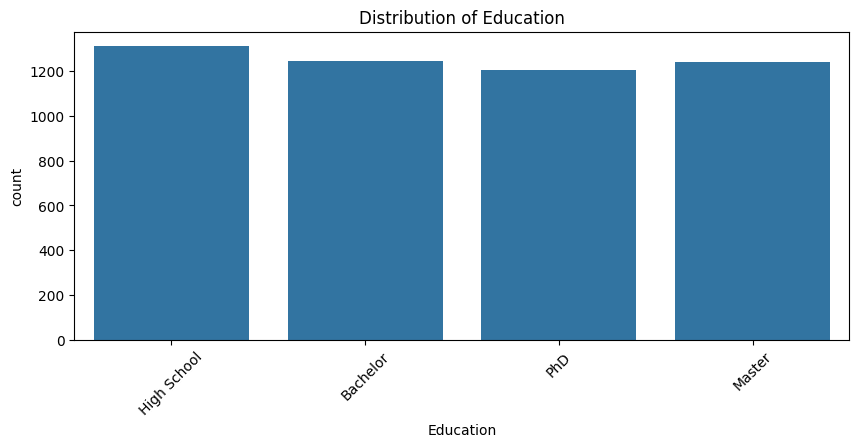

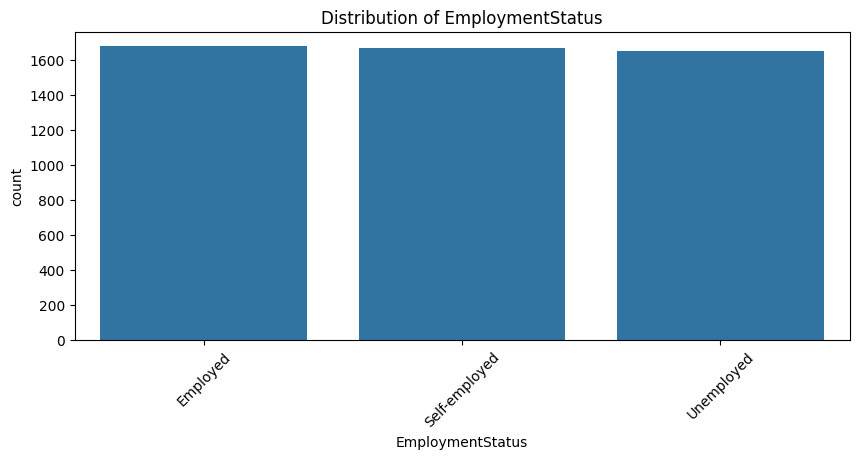

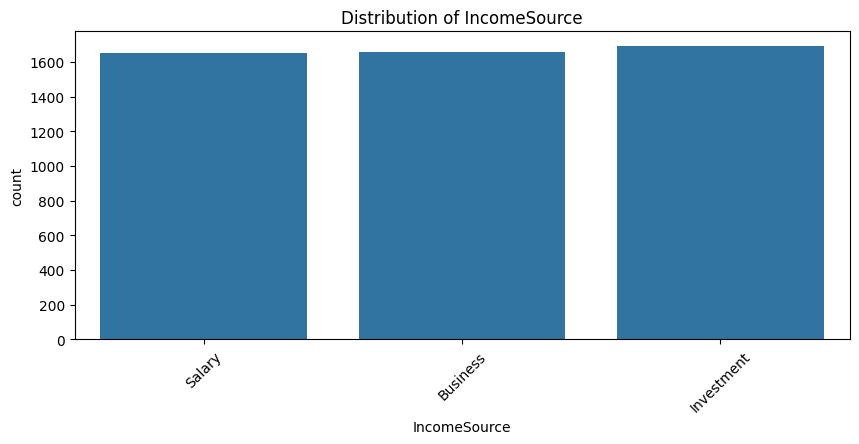

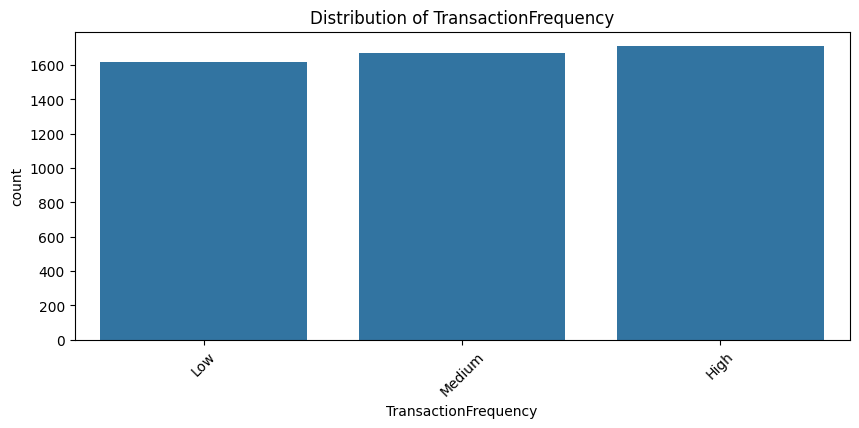

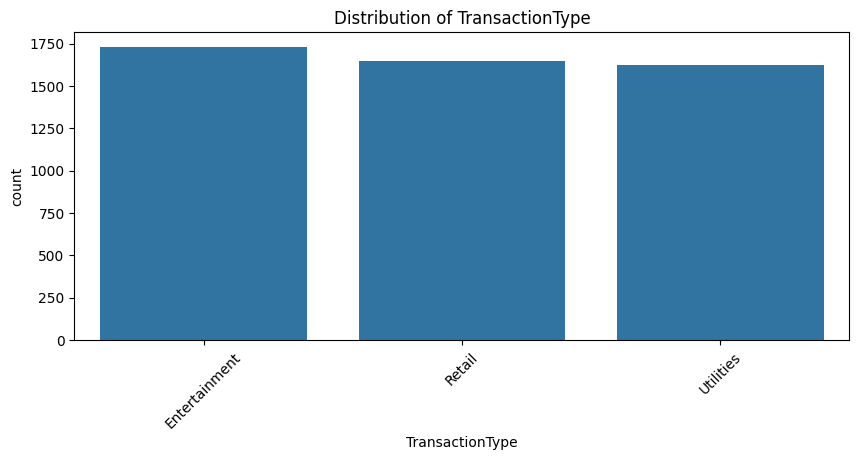

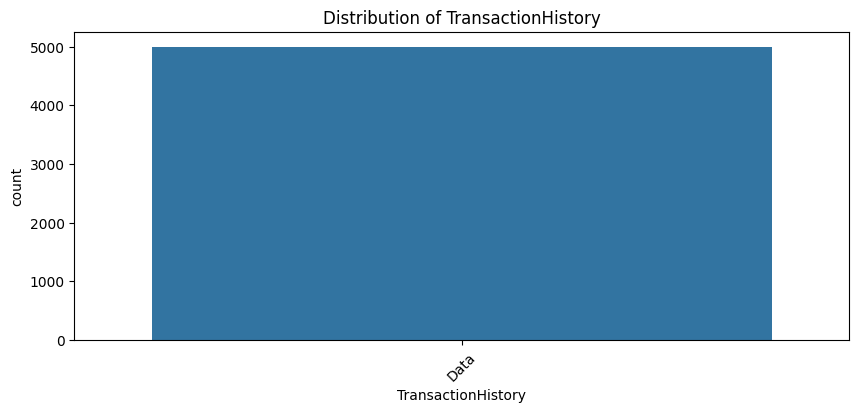

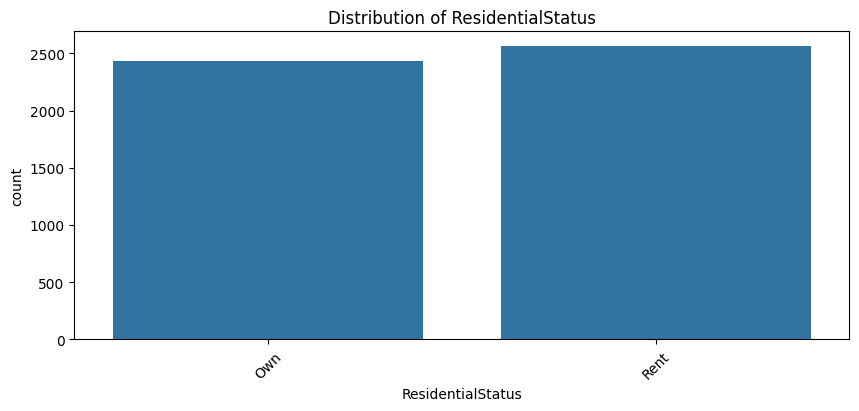

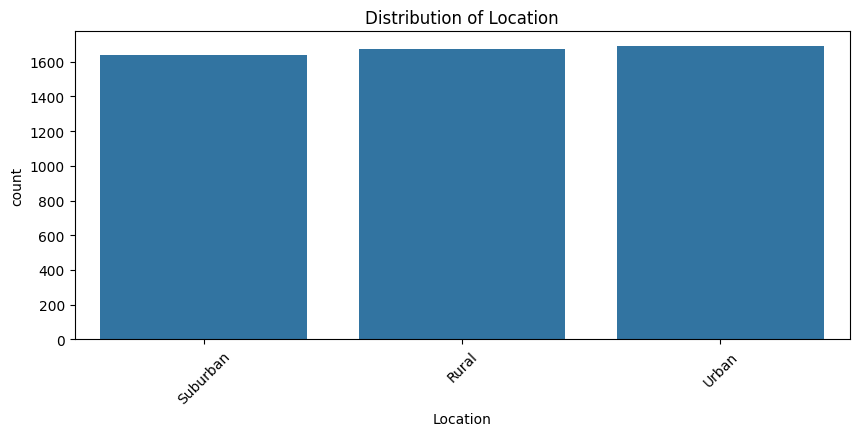

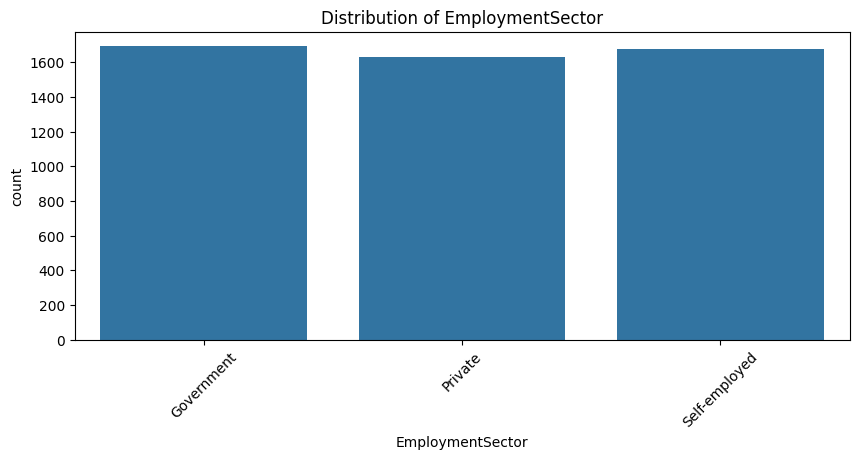

In [ ]:
# Categorical data visualization
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=data)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

Relationship between Features and Target Variable

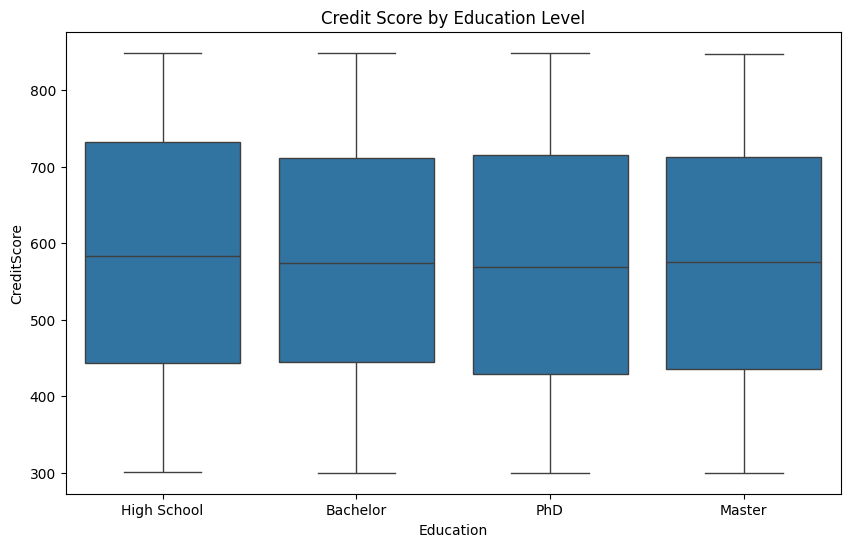

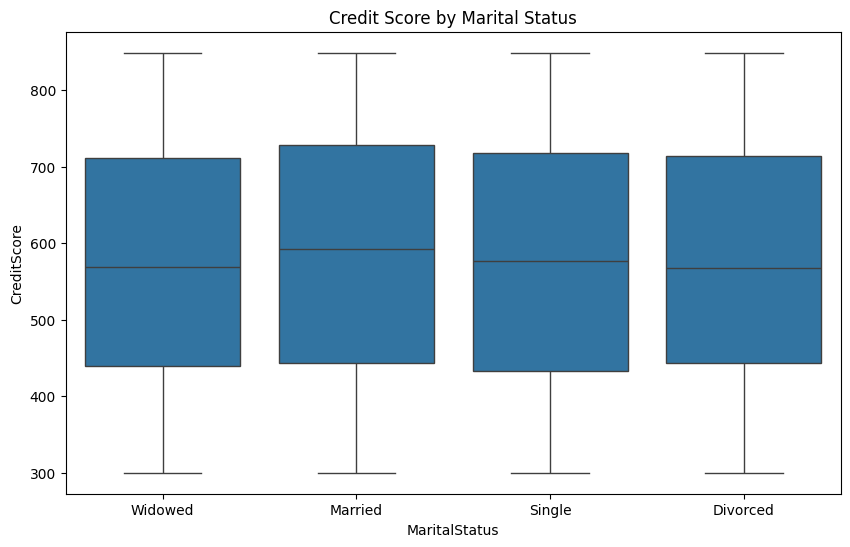

In [ ]:
# Plotting the relationship between some key features and the target variable 'CreditScore'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='CreditScore', data=data)
plt.title('Credit Score by Education Level')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='MaritalStatus', y='CreditScore', data=data)
plt.title('Credit Score by Marital Status')
plt.show()


Data Preprocessing

In [6]:
# Data Splitting
X = data.drop(['CreditScore', 'CreditBinary'], axis=1)
y = data['CreditBinary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing Steps
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

In [ ]:

# Define the models
models = {
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'RandomForest': RandomForestClassifier(),
    'Voting': VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ], voting='soft')
}

# Evaluate each model
for name, model in models.items():
    # Create a pipeline that includes preprocessing and PCA followed by the model
    pipeline = make_pipeline(preprocessor, PCA(n_components=5), model)

    # Define the evaluation procedure (repeated stratified k-fold cross-validation)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Evaluate the model and collect the scores
    n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    # Report performance
    print(f'{name}: Mean Accuracy: {np.mean(n_scores):.4f} (Std: {np.std(n_scores):.4f})')

# Depending on the results, you can refine the chosen model by tuning its hyperparameters


KNN: Mean Accuracy: 0.6601 (Std: 0.0176)
LogisticRegression: Mean Accuracy: 0.7230 (Std: 0.0010)
SVM: Mean Accuracy: 0.7230 (Std: 0.0010)
RandomForest: Mean Accuracy: 0.7104 (Std: 0.0081)
Voting: Mean Accuracy: 0.7230 (Std: 0.0010)


In [ ]:
# Define the Logistic Regression pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(LogisticRegression(max_iter=10000))),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Define the SVM pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Define GridSearchCV parameters for Logistic Regression
logistic_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

# Define GridSearchCV parameters for SVM
svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf']
}

# Model Training and Hyperparameter Tuning
# Run GridSearchCV for Logistic Regression
logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5, scoring='accuracy')
logistic_grid_search.fit(X_train, y_train)

# Run GridSearchCV for SVM
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score for Logistic Regression
print("Logistic Regression best parameters:", logistic_grid_search.best_params_)
print("Logistic Regression best score:", logistic_grid_search.best_score_)

# Print the best parameters and the corresponding score for SVM
print("SVM best parameters:", svm_grid_search.best_params_)
print("SVM best score:", svm_grid_search.best_score_)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Now transform both the training and the test set
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# If the ColumnTransformer already includes scaling, you don't need to apply StandardScaler again
# If not, apply StandardScaler or another scaler as needed

# Now the data is ready to be fed into the neural network
# Continue with the model definition, compilation, and training as shown in the previous example

